In [1]:
using Turing, Plots, LinearAlgebra, Distributions, AdvancedVI, DelimitedFiles, DataFrames

In [2]:
#Generate data
using Random
import Distributions: pdf, MvNormal, rand

Random.seed!(1) # Set random seed

T = 40 # Number of timepoints

# Generative parameters
mu_0 = [8.0, 1.0] # Prior mean
V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
F = [1.0 0.2; 
     -0.5 0.8] # Process matrix
H = [1.0 0.0; 
     0.0 1.0] # Observation matrix
Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance

# Data
x_hat = Vector{Vector{Float64}}(undef, T)
y_hat = Vector{Vector{Float64}}(undef, T)
prior_x = MvNormal(mu_0, V_0)
process_noise_dist = MvNormal(zeros(2), Q)
obs_noise_dist = MvNormal(zeros(2), R)

x_hat[1] = rand(prior_x)
y_hat[1] = H*x_hat[1] + rand(obs_noise_dist)
for t = 2:T
    x_hat[t] = F*x_hat[t-1] + rand(process_noise_dist) # Execute process
    y_hat[t] = H*x_hat[t] + rand(obs_noise_dist) # Draw observation
end
;

In [4]:
@model function BLDS(y)
    # Generative parameters
    mu_0 = [8.0, 1.0] # Prior mean
    V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
    F = [1.0 0.2; 
         -0.5 0.8] # Process matrix
    H = [1.0 0.0; 
         0.0 1.0] # Observation matrix
    Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
    R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance
    T = 40 # Number of timepoints
    
    # Priors
    a ~ MvNormal(zeros(4),diagm(0=>ones(4)))
    x = Vector{Vector}(undef,T)
    x[1] ~ MvNormal(mu_0, V_0)
    
    y[1] ~ MvNormal(H*x[1], R) # Observation model
    
    for t = 2:T
        x[t] ~ MvNormal(reshape(a,(2,2))*x[t-1], Q) # Process model
        y[t] ~ MvNormal(H*x[t], R) # Observation model
    end
end

BLDS (generic function with 2 methods)

In [5]:
etime1 = @elapsed advi = ADVI(10, 100);
etime2 = @elapsed q = vi(BLDS(y_hat), advi);
total_time = etime1 + etime2

n_its = 10
F_mf = Vector{Float64}(undef, n_its)
F_x = Vector{Float64}(undef, n_its)

F_mf[1] = - AdvancedVI.elbo(advi, q, BLDS(y_hat), 1000);
F_x[1] = total_time

for i=2:n_its
    etime = @elapsed q = vi(BLDS(y_hat), advi, q);
    total_time += etime
    F_mf[i] = - AdvancedVI.elbo(advi, q, BLDS(y_hat), 1000);
    F_x[i] = total_time
end

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 5693901028889772235
└ @ AdvancedVI /Users/sakbayrak/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:06
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 1912484691524817020
└ @ AdvancedVI /Users/sakbayrak/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:03
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 17288133029080640437
└ @ AdvancedVI /Users/sakbayrak/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:03
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 18009562444221814251
└ @ AdvancedVI /Users/sakbayrak/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:03
┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) =

In [6]:
F_mf

10-element Array{Float64,1}:
 10406.116060836892
  5638.112115697528
  2628.6785314501185
  1137.395612739097
   463.16684676226225
   188.33858960904658
    99.21459664343138
    90.58114042561118
    89.9506460980364
    90.28545687645153

In [7]:
a_est = mean(rand(q,1000),dims=2)[1:4]

4-element Array{Float64,1}:
  1.0112752580182218
 -0.4946083819906158
  0.20977059516712238
  0.7943484495849322

In [8]:
writedlm("ADVIFreeEnergy.txt", F_mf)
writedlm("ADVIFETime.txt", F_x)

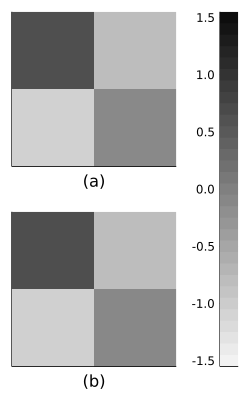

In [10]:
F_est = reshape(a_est,(2,2))
hms = [heatmap(F_est, legend=:none, xticks=:none, yticks=:none, color=:greys, clims=(-1.5,1.5), xlabel="(a)"), 
       heatmap(F, legend=:none, xticks=:none, yticks=:none, color=:greys, clims=(-1.5,1.5), xlabel="(b)")]

l = @layout[grid(2,1) a{0.1w}] # Stack a layout that rightmost one is for color bar
p = plot(hms..., heatmap(collect(1.5:-0.1:-1.5).*ones(31,1), legend=:none, xticks=:none, yticks=(1:5:31, string.(-1.5:0.5:1.5)), color=:grays), layout=l, size = (250, 400)) # Plot them set y values of color bar accordingly